In [11]:
import numpy as np
import scipy.io
import scipy.linalg
from scipy import signal
from scipy.linalg import fractional_matrix_power as matpow
from ssid import okid, ExtractModes
from control.matlab import * #need for "ss"
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from matplotlib import pyplot as plt


# Test ERA on Brunton Data

In [12]:
# Load data
p = 2   # Number of outputs
q = 2   # Number of inputs
n = 100 # State dimension (Number of structural dofs x 2)
r = 10  # Reduced model order ()
dt = 1  # Timestep
bruntondata = scipy.io.loadmat("./brunton_matlab/brunton_data.mat")
yImpulseFull = bruntondata['yFull']
yImpulse = bruntondata['YY']
uRandom = bruntondata['uRandom']
yRandom = bruntondata['yRandom']
print(yImpulse.shape)

(2, 2, 52)


In [13]:
# okid.okid(yRandom,uRandom,dt=1,kmax=200,orm=52,mro=100)

Dimensions
- p = Number of outputs (measured dof or ndof)
- q = Number of inputs (ngdof)
- n = State dimension (2ndof)
- r = Reduced model order (choose)

Full model
- Dimensions of $\mathbf{A}$: n x n
- Dimensions of $\mathbf{B}$: n x q
- Dimensions of $\mathbf{C}$: p x n
- Dimensions of $\mathbf{D}$: p x q

Reduced model
- Dimensions of $\mathbf{\tilde{A}}$: r x r
- Dimensions of $\mathbf{\tilde{B}}$: r x q
- Dimensions of $\mathbf{\tilde{C}}$: p x r
- Dimensions of $\mathbf{\tilde{D}}$: p x q

In [14]:
# example state evolution with unit impulse input

from sympy.matrices import Matrix, eye
B = Matrix(np.array([['a','b','c'],['d','e','f'],['g','h','i']]))
u1 = Matrix([1,0,0])
u2 = Matrix([0,1,0])
u3 = Matrix([0,0,1])
U = eye(3)

Bu1 = Matrix(B*u1).T
Bu2 = Matrix(B*u2).T
Bu3 = Matrix(B*u3).T

# display("B = ", B)
# display("U = ", U)
# display("u1 = ", u1)
# display("u2 = ", u2)
# display("u3 = ", u3)
# display("[Bu1, Bu2, Bu3] = ", Bu1.T.row_join(Bu2.T.row_join(Bu3.T)))
# display("BU = ", B*U)

# print("this illustrates that the desired impulse response (Y) is the matrix",
#       "where each column corresponds to the column vector of output response (yi)",
#       "corresponding to an input column vector where the ith element is one",
#       "and all others are zero (ui).")

In [15]:
## Compute ERA from brunton's impulse response
mco = int(np.floor((yImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
print(yImpulse.shape)
Ar,Br,Cr,Dr,HSVs = okid.era(yImpulse,mco,mco,p,q,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)

(2, 2, 52)


# Impulse Response Experiment 1: Single Column, Different Directions

In [16]:
## Load impulse response data from hayward opensees
# exp = "changecol"
exp = "changedof"

input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
input21  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u1.txt")
output11 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output21 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")

input12  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u2.txt")
input22  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u2.txt")
output12 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output22 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")
nt = len(input11)
dt = 0.1


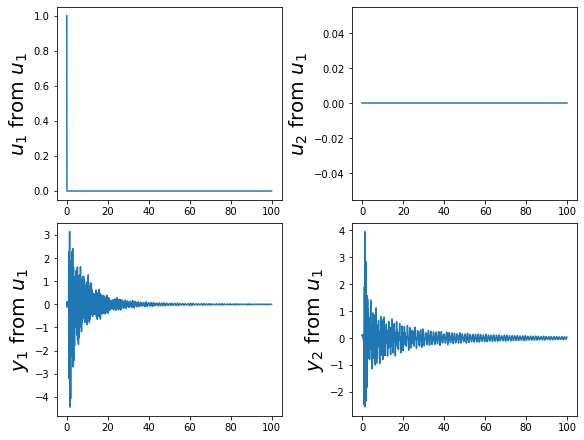

In [17]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input11)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input21)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{1}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output11)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output21)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20);

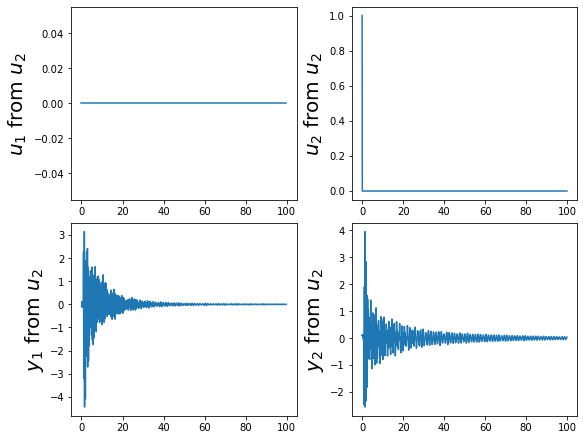

In [18]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input12)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{2}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input22)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{2}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output12)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output22)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20);

In [19]:
# Construct output data array
yOpsImpulse = np.array([[output11,output12],[output21,output22]])
print(yOpsImpulse.shape)

(2, 2, 1000)


In [23]:
## Compute ERA from impulse response
from ssid import markov
r = 20
mco = int(np.floor((yOpsImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = okid.era(yOpsImpulse,mco,mco,p,q,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)
sysERA2 = signal.StateSpace(Ar,Br,Cr,Dr, dt=dt)
Y = markov.okid(output22,input12,nt)
A,B,C,D,HSVs = okid.era(Y,mco,mco,p,q,r)
sysOKIDERA = ss(A,B,C,D,dt)

AssertionError: 

In [ ]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERA = np.zeros((1000,p,q))
for i in range(q):
    yERA[:,:,i],times = impulse(sysERA,np.arange(start=0,stop=100,step=dt),input=i)
    # yERA[:,:,i],times = signal.impulse(sysERA2)

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=15)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,0,1], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=15)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,1,0], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=15)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label=f'ERA, {r=}')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=15)
ax[1,1].legend(fontsize=15)
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=18)
fig.supylabel(r"acceleration (in/s$^2$)", fontsize=18);

In [ ]:
freqdmp, modeshape, _, _, _, = ExtractModes.ComposeModes(0.1, Ar, Br, Cr, Dr)
print('Periods:', [1/f for f in sorted(freqdmp[:,0])])

In [ ]:
modes = ExtractModes.modes(0.1, Ar, Cr)
n_modes = 5

from collections import defaultdict
ImpulsePeriods = defaultdict(dict)
ImpulsePeriods[exp] = [1/f for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])]
print('Periods:', ImpulsePeriods[exp])

for i in list(modes.keys()):
    print("Mode:", str(i))
    print("Condition Number:", modes[str(i)]['cnd'])
    print("Period:", 1/modes[str(i)]['freq'])
    print("Damping:", modes[str(i)]['damp'])
    print("Mode Shape:", modes[str(i)]['modeshape'])


print(ImpulsePeriods[exp])
print(exp)

In [ ]:
## ERA/DC
r = 50
l = 0
g = 1
a = 0
b = 0
mco = int(np.floor((yOpsImpulse.shape[2]-1-l-(a+1+b+1)*g)/2)) # m_o = m_c = (nt-1-l-(a+b)*g)/2
print(mco)
Ar,Br,Cr,Dr,HSVs = okid.era_dc(yOpsImpulse,mco,mco,p,q,r,l,g,a,b)
sysERADC = ss(Ar,Br,Cr,Dr,dt)

In [ ]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERADC = np.zeros((1000,p,q))
for i in range(q):
    yERADC[:,:,i],times = impulse(sysERADC,np.arange(start=0,stop=100,step=dt),input=i)
    # yERA[:,:,i],times = signal.impulse(sysERA2)

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].step(times,yERADC[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=15)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,0,1], '--')
ax[0,1].step(times,yERADC[:,0,1], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=15)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,1,0], '--')
ax[1,0].step(times,yERADC[:,1,0], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=15)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label=f'ERA, {r=}')
ax[1,1].step(times,yERADC[:,1,1], '--', label=f'ERA/DC, {r=}, {l=}, {g=}, {a=}, {b=}')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=15)
ax[1,1].legend(fontsize=15)
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=18)
fig.supylabel(r"acceleration (in/s$^2$)", fontsize=18);

In [ ]:
modes = ExtractModes.modes(0.1, Ar, Cr)
n_modes = 5
periods = [1/f for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])]
print('Periods:', periods)
periodsops = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:8]
print('Periods Opensees:', periodsops)
ImpulsePeriods['changedof']

# Impulse Response Experiment 2: 2 Columns, Same Direction

In [ ]:
## Load impulse response data from hayward opensees
exp = "changecol"
# exp = "changedof"

input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
input21  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u1.txt")
output11 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output21 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")

input12  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u2.txt")
input22  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u2_u2.txt")
output12 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y1_u2.txt")
output22 = np.loadtxt("./hwd_ops_impulse/"+exp+"/y2_u2.txt")
nt = len(input11)
dt = 0.1


In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input11)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input21)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{1}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output11)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output21)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=20);

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), input12)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{2}$", fontsize=20)
ax[0,1].plot(np.arange(start=0,stop=dt*nt,step=dt), input22)
ax[0,1].set_ylabel(r"$u_{2}$ from $u_{2}$", fontsize=20)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), output12)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=20)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), output22)
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=20);

In [ ]:
# Construct output data array
yOpsImpulse = np.array([[output11,output12],[output21,output22]])
print(yOpsImpulse.shape)

In [ ]:
## Compute ERA from impulse response
r = 20
mco = int(np.floor((yOpsImpulse.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
Ar,Br,Cr,Dr,HSVs = okid.era(yOpsImpulse,mco,mco,p,q,r)
sysERA = ss(Ar,Br,Cr,Dr,dt)

In [ ]:
dt = 0.1
fig, ax = plt.subplots(2,2, figsize=(14,6), constrained_layout=True)
yERA = np.zeros((1000,p,q))
for i in range(q):
    yERA[:,:,i],times = impulse(sysERA,np.arange(start=0,stop=100,step=dt),input=i)

ax[0,0].step(times, output11/dt, label='original')
ax[0,0].step(times,yERA[:,0,0], '--')
ax[0,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=15)
ax[0,1].step(times, output12/dt, label='original')
ax[0,1].step(times,yERA[:,0,1], '--')
ax[0,1].set_ylabel(r"$y_{1}$ from $u_{2}$", fontsize=15)
ax[1,0].step(times, output21/dt, label='original')
ax[1,0].step(times,yERA[:,1,0], '--')
ax[1,0].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=15)
ax[1,1].step(times, output22/dt, label='original')
ax[1,1].step(times,yERA[:,1,1], '--', label=f'ERA, {r=}')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{2}$", fontsize=15)
ax[1,1].legend(fontsize=15)
for axi in ax:
    for axj in axi:
        axj.set_xlim(0,10)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=18)
fig.supylabel(r"acceleration (in/s$^2$)", fontsize=18);

In [ ]:
freqdmp, modeshape, _, _, _, = ExtractModes.ComposeModes(0.1, Ar, Br, Cr, Dr)
print('Periods:', [1/f for f in sorted(freqdmp[:,0])])

In [ ]:
modes = ExtractModes.modes(0.1, Ar, Cr)
n_modes = 5

ImpulsePeriods[exp] = [1/f for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])]
print('Periods:', ImpulsePeriods[exp])

for i in list(modes.keys()):
    print("Mode:", str(i))
    print("Condition Number:", modes[str(i)]['cnd'])
    print("Period:", 1/modes[str(i)]['freq'])
    print("Damping:", modes[str(i)]['damp'])
    print("Mode Shape:", modes[str(i)]['modeshape'])

# Modal Identification from Impulse Response Experiments

In [ ]:
# nModes = len(Periods['ops'])
nModes = 5
ImpulsePeriods['ops'] = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:nModes]

fig, ax = plt.subplots(figsize=(9,5), tight_layout=True)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
ind = np.arange(nModes)
width = 0.25
ax.bar(ind-width, ImpulsePeriods['ops'], width, label="original (numerical model eigensolution)", color="lightgray", edgecolor="k", linewidth=0.5)
ax.bar(ind, ImpulsePeriods['changedof'][:nModes], width, label=r"predicted by ERA with IO$_{1}$", color=colors[0], edgecolor="k", linewidth=0.5)
ax.bar(ind+width, ImpulsePeriods['changecol'][:nModes], width, label=r"predicted by ERA with IO$_{2}$", color=colors[1], edgecolor="k", linewidth=0.5)
ax.set_xticklabels(np.arange(nModes+1))
ax.set_ylim((0,1.6))
ax.set_xlabel('Mode', fontsize=15)
ax.set_ylabel('Period (s)', fontsize=15)
ax.tick_params(axis='x', labelsize=13, bottom=False)
ax.tick_params(axis='y', labelsize=13)
ax.legend(fontsize=13)
rects = ax.patches
height = rects[0].get_height()
ax.text(rects[0].get_x() + 3*width/2, height+0.1, r"IO$_{1}$", ha="center", va="bottom", fontsize=14);
ax.text(rects[0].get_x() + 5*width/2, height+0.1, r"IO$_{2}$", ha="center", va="bottom", fontsize=14);

# Real Time History Data

In [ ]:
# See the real response data to test

import pickle
from numpy import pi
from datetime import datetime
from CE58658.utilities import husid

with open('../../CalTrans.Hayward/Studies/rawRHs.dat', 'rb') as f:
    rawRHs = pickle.load(f)

def plotSensorRH(rawRHs, event_date, channel_numbers, dt, windowed=False):   
    event = rawRHs[event_date]

    accel_unit_label = r"$\ddot{u}$ (g)"
    accel_scale = 1/980.665
    displ_unit_label = r"$u$ (in)"
    displ_scale = 1/2.54

    fig, ax = plt.subplots(len(channel_numbers), 2, figsize=(12,1.75*len(channel_numbers)), constrained_layout=True)
    if dt is not None:
        x_units = "s"
    else:
        dt = 1.0
        x_units = "timestep"
    sensorRH0 = event['24']['accel']*accel_scale
    times = dt*np.arange(len(sensorRH0))
    if windowed:
        window = husid(sensorRH0, False, dt, lb=0.025, ub=0.975)
        times = times[window[0]:window[1]]
    else:
        window = [0,len(sensorRH0)]
        fig, ax = plt.subplots(1,2,figsize=(15,3))

    accels = defaultdict(dict)
    for i,nm in enumerate(channel_numbers):
        accel_series = event[nm]['accel'][window[0]:window[1]]*accel_scale
        accels[nm] = event[nm]['accel']*accel_scale
        displ_series = event[nm]['displ'][window[0]:window[1]]*displ_scale
        direction = event[nm]['direction']
        channel_name = event[nm]['channel_name']
        ax[i,0].plot(times, accel_series, linewidth=0.75)
        ax[i,0].set_ylabel(f"{accel_unit_label}")
        ax[i,0].set_title(f"Channel {nm} ({channel_name}) ({direction})")
        ax[i,1].plot(times, displ_series, linewidth=0.75)
        ax[i,1].set_ylabel(f"{displ_unit_label}")
        ax[i,1].set_title(f"Channel {nm} ({channel_name}) ({direction})")
    ax[-1,0].set_xlabel(f"time ({x_units})")
    ax[-1,1].set_xlabel(f"time ({x_units})")
    fig.suptitle(f"Response History of {datetime.strptime(event_date, '%Y-%m-%dT%H:%M:%S')}")
    fig.align_labels()
    plt.show()
    return accels


CHANNELS = {
# channel node dof rotationangle locationname
    "1": (1031, 3, 37.66*pi/180, "abutment_1"),
    "2": (1031, 2, 37.66*pi/180, "abutment_1"),
    "3": (1031, 1, 37.66*pi/180, "abutment_1"),
    "6": (307, 1, 31.02*pi/180, "bent_3_south_column_grnd_level"),
    "7": (307, 2, 31.02*pi/180, "bent_3_south_column_grnd_level"),
    "11": (1030, 3, 37.66*pi/180, "deck_level_near_abut_1"),
    "12": (1030, 1, 37.66*pi/180, "deck_level_near_abut_1"),
    "13": (1030, 2, 37.66*pi/180, "deck_level_near_abut_1"),
    "14": (304, 1, 31.02*pi/180, "bent_3_deck_level"),
    "15": (304, 2, 31.02*pi/180, "bent_3_deck_level"),
    # "16": (30003, 3, ((31.02+26.26)/2)*pi/180, "midspan_between_bents_3_4_deck"),
    "17": (401, 1, 26.26*pi/180, "bent_4_north_column_grnd_level"),
    "18": (401, 2, 26.26*pi/180, "bent_4_north_column_grnd_level"),
    "19": (402, 1, 26.26*pi/180, "bent_4_north_column_top"),
    "20": (402, 2, 26.26*pi/180, "bent_4_north_column_top"),
    "21": (405, 3, 26.26*pi/180, "bent_4_deck_level"),
    "22": (405, 1, 26.26*pi/180, "bent_4_deck_level"),
    "23": (405, 2, 26.26*pi/180, "bent_4_deck_level"),
    "24": (407, 1, 26.26*pi/180, "bent_4_south_column_grnd_level"),
    "25": (407, 2, 26.26*pi/180, "bent_4_south_column_grnd_level")
}

full_channel_list = list(CHANNELS.keys())

event_dates = ['2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-07-23T15:59:00', '2021-08-03T19:52:00']
accelRHs = defaultdict(dict)
for event_date in event_dates:
    # accelRHs[event_date] = plotSensorRH(rawRHs, event_date, ["18", "25", "20", "23"], 0.01, windowed=True)
    accelRHs[event_date] = plotSensorRH(rawRHs, event_date, full_channel_list, 0.01, windowed=True)

# TH Experiment: Event 1 (6/24)

In [ ]:
## Load time history response data
exp = "exp1" # 6/24
i = 0
print(event_dates[i])

cgs_input   = accelRHs[event_dates[i]]['18']
window = husid(cgs_input, False, dt, lb=0.03, ub=0.9)
cgs_input = cgs_input[window[0]:window[1]]
ops_input   = np.loadtxt("./hwd_ops_th/"+exp+"/u.txt")[window[0]:window[1]]/386.088583
cgs_output1 = accelRHs[event_dates[i]]['20'][window[0]:window[1]]
ops_output1 = np.loadtxt("./hwd_ops_th/"+exp+"/y1.txt")[window[0]:window[1]]/386.088583
cgs_output2 = accelRHs[event_dates[i]]['23'][window[0]:window[1]]
ops_output2 = np.loadtxt("./hwd_ops_th/"+exp+"/y2.txt")[window[0]:window[1]]/386.088583

nt = len(cgs_input)
print(nt)
dt = 0.01

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_input)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_input)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=14)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output1)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output1)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=14)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output2, label='sensor')
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output2, label='numerical')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=14)
ax[1,1].legend(fontsize=12)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
# Construct output data array
yOpsTH = np.array([[ops_output1],[ops_output2]])
yCGSTH = np.array([[cgs_output1],[cgs_output2]])
print(yOpsTH.shape)
print(yCGSTH.shape)

In [ ]:
StateSpaces = defaultdict(dict)

In [ ]:
## Compute ERA from TH response
r = 20
p = 2
q = 1
print((p,q))
mco = int(np.floor((yOpsTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
print(mco)
# mco=1000
StateSpaces[exp]['ops'] = okid.era(yOpsTH,mco,mco,p,q,r)
StateSpaces[exp]['cgs'] = okid.era(yCGSTH,mco,mco,p,q,r)

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
sysERA_ops = ss(Ar,Br,Cr,Dr,dt)
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
sysERA_cgs = ss(Ar,Br,Cr,Dr,dt)

yERA_ops = np.zeros((nt,p,q))
yERA_cgs = np.zeros((nt,p,q))
for i in range(q):
    yERA_ops[:,:,i],times = impulse(sysERA_ops,np.arange(start=0,stop=nt*dt,step=dt),input=i)
    yERA_cgs[:,:,i],times = impulse(sysERA_cgs,np.arange(start=0,stop=nt*dt,step=dt),input=i)

fig, ax = plt.subplots(1,2, figsize=(12,3), constrained_layout=True)
ax[0].step(times, ops_output1/dt)
ax[0].step(times, yERA_ops[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, ops_output2/dt, label='numerical')
ax[1].step(times, yERA_ops[:,1,0], '--', label=f'numerical ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)
for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14)

fig, ax = plt.subplots(1,2, figsize=(12,3), constrained_layout=True)
ax[0].step(times, cgs_output1/dt)
ax[0].step(times, yERA_cgs[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, cgs_output2/dt, label='sensor')
ax[1].step(times, yERA_cgs[:,1,0], '--', label=f'sensor ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)
for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
Periods = defaultdict(dict)

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
modes_ops = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['ops'] = [1/f for f in sorted([modes_ops[i]['freq'] for i in list(modes_ops.keys())])]
# print([d for d in sorted([modes_ops[str(i)]['damp'] for i in list(modes_ops.keys())])])
print('Opensees Periods:', Periods[exp]['ops'])
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
modes_cgs = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['cgs'] = [1/f for f in sorted([modes_cgs[i]['freq'] for i in list(modes_cgs.keys())])]
print('CGS Periods:', Periods[exp]['cgs'])

# TH Experiment: Event 2 (6/29)

In [ ]:
## Load time history response data
exp = "exp2" # 6/29
i = 1
print(event_dates[i])

cgs_input   = accelRHs[event_dates[i]]['18']
window = husid(cgs_input, False, dt, lb=0.02, ub=0.995)
cgs_input = cgs_input[window[0]:window[1]]
ops_input   = np.loadtxt("./hwd_ops_th/"+exp+"/u.txt")[window[0]:window[1]]/386.088583
cgs_output1 = accelRHs[event_dates[i]]['20'][window[0]:window[1]]
ops_output1 = np.loadtxt("./hwd_ops_th/"+exp+"/y1.txt")[window[0]:window[1]]/386.088583
cgs_output2 = accelRHs[event_dates[i]]['23'][window[0]:window[1]]
ops_output2 = np.loadtxt("./hwd_ops_th/"+exp+"/y2.txt")[window[0]:window[1]]/386.088583

nt = len(cgs_input)
dt = 0.01

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_input)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_input)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=14)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output1)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output1)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=14)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output2, label='sensor')
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output2, label='numerical')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=14)
ax[1,1].legend(fontsize=12)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
# Construct output data array
yOpsTH = np.array([[ops_output1],[ops_output2]])
yCGSTH = np.array([[cgs_output1],[cgs_output2]])
print(yOpsTH.shape)
print(yCGSTH.shape)

In [ ]:
u = ops_input[None,:]
plt.plot(u[0,:])

y = yOpsTH.reshape(yOpsTH.shape[0],yOpsTH.shape[2])
plt.plot(y[0,:])
plt.plot(y[1,:]);

In [ ]:
## Get impulse response (Markov parameters)

yImpulseOps = okid.OKID_brunton(y, u, 300)

yImpulseOps.shape


In [ ]:
u = ops_input[None,:]
plt.plot(u[0,:], label='input')

y = yOpsTH.reshape(yOpsTH.shape[0],yOpsTH.shape[2])
plt.plot(yImpulseOps[0,:], label='calculated output 1')
plt.plot(yImpulseOps[1,:], label='calculated output 2')
plt.plot(y[0,:], label='output 1')
plt.plot(y[1,:], label='ouptut 2')
plt.ylim((-0.03,0.03))
plt.legend();

In [ ]:
## Compute ERA from TH response
r = 20
p = 2
q = 1
print((p,q))
mco = int(np.floor((yOpsTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
StateSpaces[exp]['ops'] = okid.era(yOpsTH,mco,mco,p,q,r)
StateSpaces[exp]['cgs'] = okid.era(yCGSTH,mco,mco,p,q,r)
# StateSpaces[exp]['cgs2'] = okid._era_ya(mco,p,yCGSTH.shape[0],q,yCGSTH,r)

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
sysERA_ops = ss(Ar,Br,Cr,Dr,dt)
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
sysERA_cgs = ss(Ar,Br,Cr,Dr,dt)

yERA_ops = np.zeros((nt,p,q))
yERA_cgs = np.zeros((nt,p,q))
for i in range(q):
    yERA_ops[:,:,i],times = impulse(sysERA_ops,np.arange(start=0,stop=nt*dt,step=dt),input=i)
    yERA_cgs[:,:,i],times = impulse(sysERA_cgs,np.arange(start=0,stop=nt*dt,step=dt),input=i)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, ops_output1/dt)
ax[0].step(times, yERA_ops[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, ops_output2/dt, label='numerical')
ax[1].step(times, yERA_ops[:,1,0], '--', label=f'numerical ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)
for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, cgs_output1/dt)
ax[0].step(times, yERA_cgs[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, cgs_output2/dt, label='sensor')
ax[1].step(times, yERA_cgs[:,1,0], '--', label=f'sensor ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)

for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
modes_ops = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['ops'] = [1/f for f in sorted([modes_ops[i]['freq'] for i in list(modes_ops.keys())])]
# print([d for d in sorted([modes_ops[str(i)]['damp'] for i in list(modes_ops.keys())])])
print('Opensees Periods:', Periods[exp]['ops'])
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
modes_cgs = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['cgs'] = [1/f for f in sorted([modes_cgs[i]['freq'] for i in list(modes_cgs.keys())])]
print('CGS Periods:', Periods[exp]['cgs'])
# Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs2']
modes_cgs2 = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['cgs2'] = [1/f for f in sorted([modes_cgs2[i]['freq'] for i in list(modes_cgs2.keys())])]
# print('CGS Periods2:', Periods[exp]['cgs2'])

# TH Experiment: Event 3 (7/23)

In [ ]:
## Load time history response data
exp = "exp3" # 7/23
i = 2
print(event_dates[i])

cgs_input   = accelRHs[event_dates[i]]['18']
window = husid(cgs_input, False, dt, lb=0.1, ub=0.9)
cgs_input = cgs_input[window[0]:window[1]]
ops_input   = np.loadtxt("./hwd_ops_th/"+exp+"/u.txt")[window[0]:window[1]]/386.088583
cgs_output1 = accelRHs[event_dates[i]]['20'][window[0]:window[1]]
ops_output1 = np.loadtxt("./hwd_ops_th/"+exp+"/y1.txt")[window[0]:window[1]]/386.088583
cgs_output2 = accelRHs[event_dates[i]]['23'][window[0]:window[1]]
ops_output2 = np.loadtxt("./hwd_ops_th/"+exp+"/y2.txt")[window[0]:window[1]]/386.088583

nt = len(cgs_input)
dt = 0.01

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_input)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_input)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=14)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output1)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output1)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=14)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output2, label='sensor')
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output2, label='numerical')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=14)
ax[1,1].legend(fontsize=12)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
# Construct output data array
yOpsTH = np.array([[ops_output1],[ops_output2]])
yCGSTH = np.array([[cgs_output1],[cgs_output2]])
print(yOpsTH.shape)
print(yCGSTH.shape)

In [ ]:
## Compute ERA from TH response
r = 20
p = 2
q = 1
print((p,q))
mco = int(np.floor((yOpsTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
StateSpaces[exp]['ops'] = okid.era(yOpsTH,mco,mco,p,q,r)
StateSpaces[exp]['cgs'] = okid.era(yCGSTH,mco,mco,p,q,r)

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces['exp3']['ops']
sysERA_ops = ss(Ar,Br,Cr,Dr,dt)
Ar,Br,Cr,Dr,HSVs = StateSpaces['exp3']['cgs']
sysERA_cgs = ss(Ar,Br,Cr,Dr,dt)
Ar1,Br1,Cr1,Dr1,HSVs1 = StateSpaces['exp2']['ops']
sysERA_ops1 = ss(Ar1,Br1,Cr1,Dr1,dt)

yERA_ops = np.zeros((nt,p,q))
yERA_ops1 = np.zeros((nt,p,q))
yERA_cgs = np.zeros((nt,p,q))
for i in range(q):
    yERA_cgs[:,:,i],times = impulse(sysERA_cgs,np.arange(start=0,stop=nt*dt,step=dt),input=i)
    yERA_ops[:,:,i],times = impulse(sysERA_ops,np.arange(start=0,stop=nt*dt,step=dt),input=i)
    yERA_ops1[:,:,i],times = impulse(sysERA_ops1,np.arange(start=0,stop=nt*dt,step=dt),input=i)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, ops_output1/dt)
ax[0].step(times, yERA_ops[:,0,0], '--')
# ax[0].step(times, yERA_ops1[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, ops_output2/dt, label='numerical')
ax[1].step(times, yERA_ops[:,1,0], '--', label=f'numerical ERA, {r=}')
# ax[1].step(times, yERA_ops1[:,1,0], '--', label=f'numerical ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)
for axi in ax:
    axi.set_xlim(0,13)
    # axi.set_ylim(-1,1)
    # axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, cgs_output1/dt)
ax[0].step(times, yERA_cgs[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, cgs_output2/dt, label='sensor')
ax[1].step(times, yERA_cgs[:,1,0], '--', label=f'sensor ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)

for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
modes_ops = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['ops'] = [1/f for f in sorted([modes_ops[i]['freq'] for i in list(modes_ops.keys())])]
# print([d for d in sorted([modes_ops[str(i)]['damp'] for i in list(modes_ops.keys())])])
print('Opensees Periods:', Periods[exp]['ops'])
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
modes_cgs = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['cgs'] = [1/f for f in sorted([modes_cgs[i]['freq'] for i in list(modes_cgs.keys())])]
print('CGS Periods:', Periods[exp]['cgs'])

# TH Experiment: Event 4 (8/3)

In [ ]:
## Load time history response data
exp = "exp4" # 8/3
i = 3
print(event_dates[i])

cgs_input   = accelRHs[event_dates[i]]['18']
window = husid(cgs_input, False, dt, lb=0.1, ub=0.9)
cgs_input = cgs_input[window[0]:window[1]]
ops_input   = np.loadtxt("./hwd_ops_th/"+exp+"/u.txt")[window[0]:window[1]]/386.088583
cgs_output1 = accelRHs[event_dates[i]]['20'][window[0]:window[1]]
ops_output1 = np.loadtxt("./hwd_ops_th/"+exp+"/y1.txt")[window[0]:window[1]]/386.088583
cgs_output2 = accelRHs[event_dates[i]]['23'][window[0]:window[1]]
ops_output2 = np.loadtxt("./hwd_ops_th/"+exp+"/y2.txt")[window[0]:window[1]]/386.088583

nt = len(cgs_input)
dt = 0.01

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_input)
ax[0,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_input)
ax[0,0].set_ylabel(r"$u_{1}$ from $u_{1}$", fontsize=14)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output1)
ax[1,0].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output1)
ax[1,0].set_ylabel(r"$y_{1}$ from $u_{1}$", fontsize=14)
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), cgs_output2, label='sensor')
ax[1,1].plot(np.arange(start=0,stop=dt*nt,step=dt), ops_output2, label='numerical')
ax[1,1].set_ylabel(r"$y_{2}$ from $u_{1}$", fontsize=14)
ax[1,1].legend(fontsize=12)
for i in range(2):
    ax[-1,i].set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
# Construct output data array
yOpsTH = np.array([[ops_output1],[ops_output2]])
yCGSTH = np.array([[cgs_output1],[cgs_output2]])
print(yOpsTH.shape)
print(yCGSTH.shape)

In [ ]:
## Compute ERA from TH response
r = 20
p = 2
q = 1
print((p,q))
mco = int(np.floor((yOpsTH.shape[2]-1)/2)) # m_o = m_c = (nt-1)/2
StateSpaces[exp]['ops'] = okid.era(yOpsTH,mco,mco,p,q,r)
StateSpaces[exp]['cgs'] = okid.era(yCGSTH,mco,mco,p,q,r)

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
sysERA_ops = ss(Ar,Br,Cr,Dr,dt)
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
sysERA_cgs = ss(Ar,Br,Cr,Dr,dt)

Ar,Br,Cr,Dr,HSVs = StateSpaces['exp4']['ops']
sysERA_ops = ss(Ar,Br,Cr,Dr,dt)
Ar,Br,Cr,Dr,HSVs = StateSpaces['exp4']['cgs']
sysERA_cgs = ss(Ar,Br,Cr,Dr,dt)
Ar1,Br1,Cr1,Dr1,HSVs1 = StateSpaces['exp2']['ops']
sysERA_ops1 = ss(Ar1,Br1,Cr1,Dr1,dt)


# yERA_ops = np.zeros((nt,p,q))
# yERA_cgs = np.zeros((nt,p,q))
# for i in range(q):
#     yERA_ops[:,:,i],times = impulse(sysERA_ops,np.arange(start=0,stop=nt*dt,step=dt),input=i)
#     yERA_cgs[:,:,i],times = impulse(sysERA_cgs,np.arange(start=0,stop=nt*dt,step=dt),input=i)

# fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
# ax[0].step(times, ops_output1/dt)
# ax[0].step(times, yERA_ops[:,0,0], '--')
# ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
# ax[1].step(times, ops_output2/dt, label='numerical')
# ax[1].step(times, yERA_ops[:,1,0], '--', label=f'numerical ERA, {r=}')

yERA_ops = np.zeros((nt,p,q))
yERA_ops1 = np.zeros((nt,p,q))
yERA_cgs = np.zeros((nt,p,q))
for i in range(q):
    yERA_cgs[:,:,i],times = impulse(sysERA_cgs,np.arange(start=0,stop=nt*dt,step=dt),input=i)
    yERA_ops[:,:,i],times = impulse(sysERA_ops,np.arange(start=0,stop=nt*dt,step=dt),input=i)
    # yERA_ops1[:,:,i],times = impulse(sysERA_ops1,np.arange(start=0,stop=nt*dt,step=dt),input=i)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, ops_output1/dt)
ax[0].step(times, yERA_ops[:,0,0], '--')
# ax[0].step(times, yERA_ops1[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, ops_output2/dt, label='numerical')
ax[1].step(times, yERA_ops[:,1,0], '--', label=f'numerical ERA, {r=}')
# ax[1].step(times, yERA_ops1[:,1,0], '--', label=f'numerical ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)
for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14)

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
ax[0].step(times, cgs_output1/dt)
ax[0].step(times, yERA_cgs[:,0,0], '--')
ax[0].set_ylabel(r"$y_{1}$", fontsize=14)
ax[1].step(times, cgs_output2/dt, label='sensor')
ax[1].step(times, yERA_cgs[:,1,0], '--', label=f'sensor ERA, {r=}')
ax[1].set_ylabel(r"$y_{2}$", fontsize=14)
ax[1].legend(fontsize=12)

for axi in ax:
    axi.set_xlim(0,nt*dt)
    axi.set_xlabel("time (s)", fontsize=14)
fig.supylabel("acceleration (g)", fontsize=14);

In [ ]:
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['ops']
modes_ops = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['ops'] = [1/f for f in sorted([modes_ops[i]['freq'] for i in list(modes_ops.keys())])]
# print([d for d in sorted([modes_ops[str(i)]['damp'] for i in list(modes_ops.keys())])])
print('Opensees Periods:', Periods[exp]['ops'])
Ar,Br,Cr,Dr,HSVs = StateSpaces[exp]['cgs']
modes_cgs = ExtractModes.modes(dt, Ar, Cr)
Periods[exp]['cgs'] = [1/f for f in sorted([modes_cgs[i]['freq'] for i in list(modes_cgs.keys())])]
print('CGS Periods:', Periods[exp]['cgs'])

# Modal Identification from Time History Experiments

In [ ]:
Periods['eigen']['ops'] = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:nModes]
opsPds = defaultdict(dict)
cgsPds = defaultdict(dict)
# event_dates = ['2021-06-24', '2021-06-29', '2021-07-24', '2021-08-03']
event_dates = ['2021-06-24', '2021-06-29', '2021-08-03']

In [ ]:
for m in range(3):
    # opsPds[str(m+1)] = [Periods['exp1']['ops'][m], Periods['exp2']['ops'][m], Periods['exp3']['ops'][m], Periods['exp4']['ops'][m]]
    opsPds[str(m+1)] = [Periods['exp1']['ops'][m], Periods['exp2']['ops'][m], Periods['exp4']['ops'][m]]
    # cgsPds[str(m+1)] = [Periods['exp1']['cgs'][m], Periods['exp2']['cgs'][m], Periods['exp3']['cgs'][m], Periods['exp4']['cgs'][m]]
    cgsPds[str(m+1)] = [Periods['exp1']['cgs'][m], Periods['exp2']['cgs'][m], Periods['exp4']['cgs'][m]]

fig, ax = plt.subplots(1,3, figsize=(11,4), tight_layout=True, sharey=True)
ax[0].set_ylim((0,1.6))
ax[0].set_ylabel("Period (s)", fontsize=14)
for m in range(3):
    ax[m].plot(event_dates, Periods['eigen']['ops'][m]*np.ones(3), '--', color='gray', label='numerical eigensolution')
    ax[m].plot(event_dates, opsPds[str(m+1)], '-o', label='numerical ERA prediction')
    ax[m].plot(event_dates, cgsPds[str(m+1)], '--o', label='sensor ERA prediction')
    ax[m].set_xlabel("Event Date", fontsize=14)
    ax[m].set_title(f"Mode {m+1}", fontsize=14)
ax[2].legend(fontsize=11);

# Event 2, OKID ERA DC

In [ ]:
event_dates = ['2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-07-23T15:59:00', '2021-08-03T19:52:00']

In [ ]:
## Load time history response data
exp = "okid_era_dc"
i = 1 # 6/29 date

input_channel_numbers = ['2', '3', '6', '7', '17', '18', '24', '25']
output_channel_numbers = ['12', '13', '14', '15', '19', '20', '22', '23']

cgs_input = np.array([accelRHs[event_dates[i]][ch] for ch in input_channel_numbers]).T
window = husid(cgs_input[:,0], False, dt, lb=0.02, ub=0.995)
cgs_input = cgs_input[window[0]:window[1], :]
cgs_output = np.array([accelRHs[event_dates[i]][ch][window[0]:window[1]] for ch in output_channel_numbers]).T

nt = len(cgs_input)
dt = 0.01

In [ ]:
A,B,C,D = okid.okid(cgs_input, cgs_output, dt=0.01, kmax=500, orm=16, mro=40)

In [ ]:
modes_cgs = ExtractModes.ComposeModes(dt, A, B, C, D)
modes_cgs

In [ ]:
modes_cgs = ExtractModes.modes(dt, A, C)
periods = [1/f for f in sorted([modes_cgs[str(i)]['freq'] for i in list(modes_cgs.keys())])]
periods